**Sentiment analysis using bagging classifier based on logistic regression**

**Importing necessary libraries**

In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import learning_curve
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import scipy.sparse 
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier,AdaBoostClassifier

**Loading the data into appropriate dataframes**

In [2]:
train=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movies=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

**Understanding data and metadata**

In [3]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


Most of the columns have very few non-null values and others do not have much bearing on the sentiment of the review.
Therefore,only two columns are chosen:
* audienceScore, as higher the score, more likely the review is positive
* genre, as some genres may be more highly rated than others, making it more likely that the review is positive

In [5]:
movies=movies[["movieid","audienceScore","genre"]]#Discarding unnecessary columns
movies

,movieid,audienceScore,genre
0,han_solo_heroic_myth_wonder_woman,50.0,"Comedy, Horror, Sci-fi"
1,voyage_tyler_durden_han_solo_stardust,NaN,Drama
2,norman_bates_ferris_bueller_hermione_granger_v...,43.0,Drama
3,elegant_hermione_granger,60.0,"Action, Mystery & thriller"
4,adventure_rocky_balboa,70.0,"Fantasy, Adventure, Animation"
...,...,...,...
143253,sherlock_holmes_surreal_james_bond,14.0,"Action, Adventure, Anime"
143254,mr._miyagi_katniss_everdeen_harmony,NaN,Drama
143255,elegant_emerald_valiant_donnie_darko,71.0,Documentary
143256,wonder_hermione_granger_hulk_v,NaN,Drama


In [6]:
movies["movieid"].value_counts()

escape_the_terminator_tyler_durden_astonish         367
silent_mystery_the_terminator                        17
crimson_james_t._kirk_marty_mcfly_hulk               17
darth_vader_dazzling_courageous_holly_golightly      16
rocky_balboa_wonder_woman_majestic_emerald           16
                                                   ... 
anakin_skywalker_frodo_baggins_t-800_black_widow      1
phantom_hannibal_lecter_don_vito_corleone_pirate      1
v_bruce_wayne_stardust                                1
mystery_lara_croft_tony_montana                       1
wonder_hermione_granger_hulk_v                        1
Name: movieid, Length: 126404, dtype: int64

There are a lot of duplicate values. One way of removing these values would be to retain the movieid with the highest score and drop other occurences of the same id. This is done in the 'Data Cleaning' section

In [7]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [8]:
test.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


**Data Cleaning**

In [9]:
movies=movies.sort_values(by="audienceScore",ascending=False)#Sorts the movies database from 100-0
movies.drop_duplicates(subset="movieid",inplace=True)#drops the lower scored (and potentially Nan) duplicates
movies

,movieid,audienceScore,genre
73588,journey_witch,100.0,"History, Drama"
116717,holly_golightly_destiny_captain_jack_sparrow_a...,100.0,"Drama, History"
12226,neo_dragon_eon_pirate,100.0,Documentary
69636,celestial_annie_hall,100.0,Drama
12236,captain_america_katniss_everdeen_intrigue,100.0,"Documentary, Music"
...,...,...,...
143248,hiccup_katniss_everdeen_captain_jack_sparrow,NaN,NaN
143251,bruce_wayne_rick_blaine_princess_leia_vito_cor...,NaN,Action
143252,james_bond_jason_bourne,NaN,"Action, Mystery & thriller"
143254,mr._miyagi_katniss_everdeen_harmony,NaN,Drama


In [10]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126404 entries, 73588 to 143256
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movieid        126404 non-null  object 
 1   audienceScore  66187 non-null   float64
 2   genre          116470 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


There are null values in both the audienceScore and the genre columns. The null values in the audienceScore can be filled by using SimpleImputer whereas fillna() method of a DataFrame can be used to fill null values in genre column

In [11]:
SI=SimpleImputer(strategy="mean")
movies["audienceScore"]=SI.fit_transform(np.array(movies["audienceScore"]).reshape(-1,1))

In [12]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126404 entries, 73588 to 143256
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   movieid        126404 non-null  object 
 1   audienceScore  126404 non-null  float64
 2   genre          116470 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


Now, a function to merge the Train and Test dataset with the metadata is defined.

In [13]:
def merge_movies(x):
    x=pd.merge(left=x,right=movies,how='left',on='movieid')
    return x
train=merge_movies(train)
test=merge_movies(test)

In [14]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,audienceScore,genre
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.0,"Comedy, Animation, Adventure, Fantasy"
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,47.0,"Holiday, Romance, Comedy, Lgbtq+"
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,80.0,Drama
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,47.0,"Action, Mystery & thriller, Sci-fi"
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE,97.0,"Crime, Drama"


In [15]:
test.head()

,movieid,reviewerName,isTopCritic,reviewText,audienceScore,genre
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...,57.0000,"Holiday, Horror, Mystery & thriller"
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...,86.0000,"Drama, Adventure"
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...,62.0000,Drama
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...,84.0000,"Drama, Mystery & thriller"
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...,56.8159,"Drama, Musical"


**Exploratory Data Analysis**

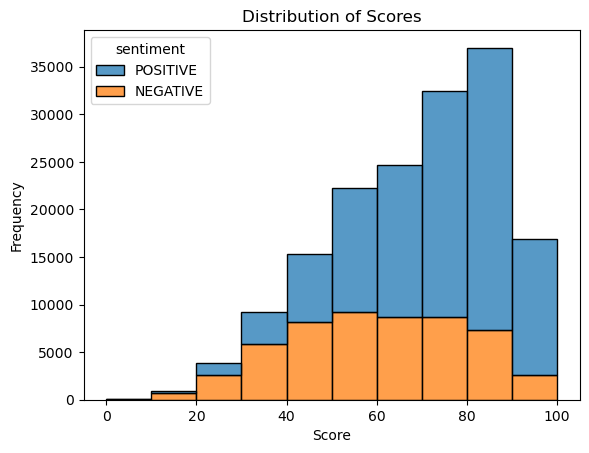

In [16]:
sns.histplot(data=train,x='audienceScore',hue="sentiment",multiple="stack",bins=10)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()

As expected, when the score of the movie increases, it is more likely that the sentiment is positive

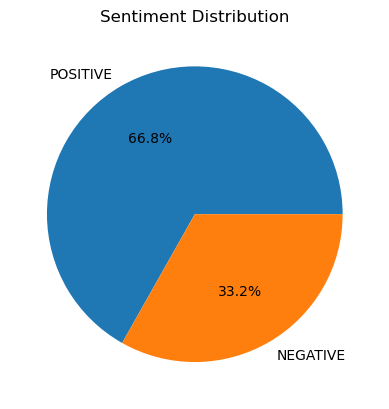

In [17]:
plt.pie(train['sentiment'].value_counts(), labels=train['sentiment'].value_counts().index, autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.show()

The percentage of positive reviews exceeds the negative reviews significantly. This may require modification to some algorithms (e.g Naive Bayes hyperparameter fit_prior)

**Preprocessing**

In [18]:
train_text=train['reviewText']
test_text=test['reviewText']
lb=LabelEncoder()
train_targ=lb.fit_transform(train['sentiment'])#using the label encoder to convert Positive and Negstive values to 1 and 0

In [19]:
train_targ

array([1, 0, 1, ..., 1, 0, 1])

To analyse the reviewText, it must first be converted to a machine readable form, and the same goes for genre. This is done by tokenising the text by using the TfidfVectorizer from sklearn.feature_extraction.text. The TfidfVectorizer converts text into a feature array considering the frequency of words for one sample as well as the rarity of the word across the entire dataset.
 
To accomplish this, first the null values are filled and the punctuation is removed.

In [20]:
def preprocess(x):
    x.fillna("",inplace=True)
    x=x.str.translate(str.maketrans('','',string.punctuation))#remove punctuation from all values
    return x
train_text=preprocess(train_text)
test_text=preprocess(test_text)
train_genre=preprocess(train["genre"])#this will fill null values and remove the commas between different genres which can then be tokenized
test_genre=preprocess(test["genre"])

Using the TfidfVectorizer, the reviewText and genre fields are converted to sparse matrices

In [21]:
# stop=["the","of","and","is","as","for","it","its",
#       "with","in","that","to","but","movie","film",
#       "story","you","be","by","have","this","has","on","an","from","what","not",
#       "more","are","at","one","so","than","all","about","his","her","if","than"]

vect=tfidf(stop_words='english')#stop_words=stop,

train_token=vect.fit_transform(train_text)
test_token=vect.transform(test_text)

review_words=vect.get_feature_names_out()

train_genre_token=vect.fit_transform(train_genre)
test_genre_token=vect.transform(test_genre)

genre_words=vect.get_feature_names_out()

In [22]:
train_token.shape

(162758, 98382)

In [23]:
train_genre_token.shape

(162758, 38)

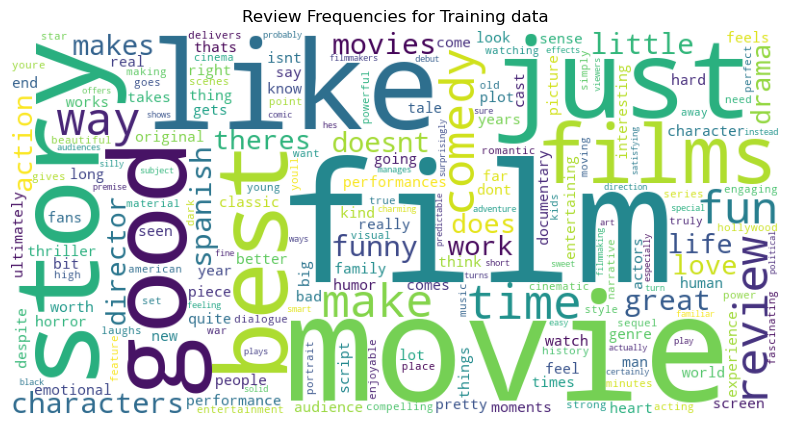

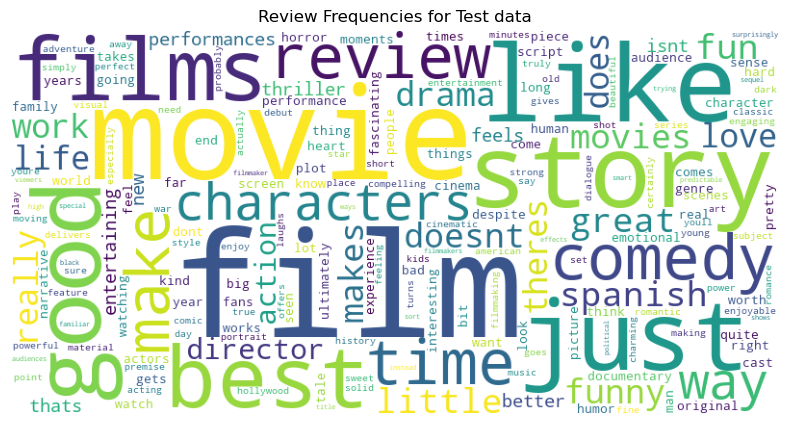

In [24]:
word_freq_dict = dict(zip(review_words, train_token.sum(axis=0).A1))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Review Frequencies for Training data')

# genre_freq_dict = dict(zip(genre_words, train_genre_token.sum(axis=0).A1))

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_freq_dict)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.title('Genre Frequencies')

word_freq_dict_test = dict(zip(review_words, test_token.sum(axis=0).A1))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_test)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Review Frequencies for Test data')

plt.show()

The three seperate sparse matrices, representing reviewText, genre and audienceScore are merged together

In [25]:
def complete_token(word_token,genre_token,merged_df):
    csr=scipy.sparse.csr_matrix(np.array(merged_df["audienceScore"]).reshape(-1,1))
    token=scipy.sparse.hstack([word_token,csr,genre_token])
    return token
train_token=complete_token(train_token,train_genre_token,train)
test_token=complete_token(test_token,test_genre_token,test)

In [26]:
train_token.shape

(162758, 98421)

In [27]:
test_token.shape

(55315, 98421)

Unused preprocessing

In [28]:
# from sklearn.preprocessing import StandardScaler
# ss=StandardScaler(with_mean=False)
# train_token=ss.fit_transform(train_token)
# test_token=ms.transform(test_token)


# from sklearn.preprocessing import MaxAbsScaler
# ms=MaxAbsScaler()
# train_token=ms.fit_transform(train_token)
# test_token=ms.transform(test_token)

# from scipy.stats.mstats import winsorize
# train["runtimeMinutes"]=winsorize(train["runtimeMinutes"],limits=(0.1,0.1))
# test["runtimeMinutes"]=winsorize(test["runtimeMinutes"],limits=(0.1,0.1))

#from sklearn.decomposition import TruncatedSVD
#svd=TruncatedSVD(n_components =10000)
# X_train=svd.fit_transform(X_train)
# svd.explained_variance_ratio_.cumsum()
# X_eval=svd.transform(X_eval)


**Train-test split**

In [29]:
X_train, X_eval, y_train, y_eval = train_test_split(train_token,train_targ,test_size=0.2,random_state=42)

Three models are now to be trained. Models chosen are Naive Bayes, Decision trees and Logistic Regression

**Model 1: Naive Bayes**

In [30]:
N_B=MultinomialNB(fit_prior=False,alpha=0.6)
N_B.fit(X_train,y_train)
N_B.score(X_eval,y_eval)

0.7809965593511919

After some minor hyperparameter tuning, the best value for alpha was determined to be 0.6

**Model 2:Decision tree**

In [31]:
dt=DecisionTreeClassifier(max_depth=50)
dt.fit(X_train,y_train)
f1_score(dt.predict(X_eval),y_eval,average='micro')

0.7177746375030721

If the depth of the decision tree is not specified, it grows till it completely fits the training data. This leads to overfitting which can be measured by the score of the decision tree on the training data. After some minor hyperparameter tunning, the depth of the tree was restricted to 50 to maximize the score on the test data

In [32]:
f1_score(dt.predict(X_train),y_train,average='micro')

0.8421194107798412

In [33]:
dt.get_depth()

50

The depth of the decision tree has been adjusted to prevent overfitting the training data

**Model 3:Logistic regression**

In [34]:
lr=LogisticRegression(solver='liblinear',max_iter=1000)#liblinear is preferred over the default lbfgs for larger datasets as it converges faster
lr.fit(X_train,y_train)
f1_score(lr.predict(X_eval),y_eval,average='micro')

0.8074158269845171

Logistic regression gives the best score out of those tested so far. The predictions given can be analysed using learning curve and confusion matrix to see what errors it is making

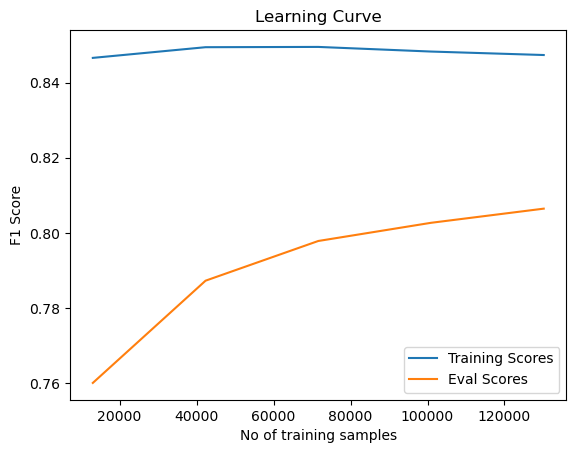

In [35]:
Train_size,Train_score,Eval_score=learning_curve(lr,train_token,train_targ,scoring="f1_micro",random_state=42,n_jobs=-1)
plt.plot(Train_size,np.mean(Train_score,axis=1),label="Training Scores")
plt.plot(Train_size,np.mean(Eval_score,axis=1),label="Eval Scores")
plt.title("Learning Curve")
plt.xlabel('No of training samples')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [36]:
print(classification_report(y_eval,lr.predict(X_eval),target_names=["0","1"]))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67     10696
           1       0.82      0.91      0.86     21856

    accuracy                           0.81     32552
   macro avg       0.79      0.75      0.77     32552
weighted avg       0.80      0.81      0.80     32552



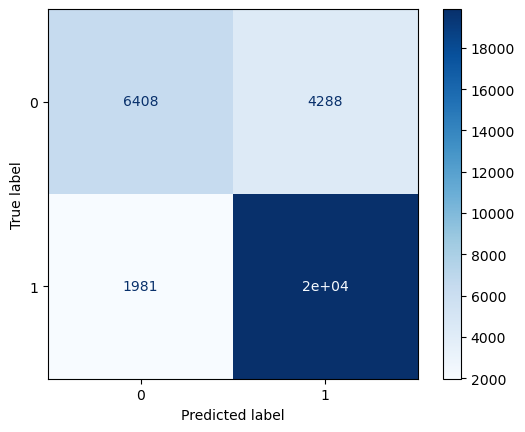

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    lr,
    X_eval,
    y_eval,
    display_labels=["0","1"],
    cmap=plt.cm.Blues
)

Most of the errors it makes are false positives. This can be rectified by using SMOTE as shown below. However, this appproach does not improve the score

In [38]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

One Logistic Regression estimator gives this f1 score. Many Logistic Regression estimators may improve the score. This can be acheived by using Bagging and setting the bootstrap parameter to False

In [39]:
bgc=BaggingClassifier(estimator=lr,n_jobs=-1,random_state=42,bootstrap=False,n_estimators=30)
bgc.fit(X_train,y_train)
f1_score(bgc.predict(X_eval),y_eval,average='micro')

0.8074158269845171

As can be seen, the score has marginally increased after using this aggregation method. Therefore, bagging is used for further hyperparameter tuning

**Hyperparameter tuning**

The main hyperparameter that affects the model performance in this case is the value of C. Smaller values of C indicate greater regularization.

In [40]:
#Commented as it takes a long time to run

# params={"estimator__C":[2.1,2.15,2.17,2.2]}
# grid_search = GridSearchCV(bgc, param_grid=params, cv=5,scoring='f1_micro',n_jobs=-1)
# grid_search.fit(train_token,train_targ)
# print("Best Hyperparameters:", grid_search.best_params_)

In [41]:
# bgc.estimator__C=grid_search.best_params_['C']
lr.C=2.17

In [42]:
bgc.fit(train_token,train_targ)

BaggingClassifier(bootstrap=False,
                  estimator=LogisticRegression(C=2.17, max_iter=1000,
                                               solver='liblinear'),
                  n_estimators=30, n_jobs=-1, random_state=42)

In [43]:
test_pred=bgc.predict(test_token)

In [44]:
submission=pd.DataFrame(columns=["id","sentiment"])
submission["id"]=[i for i in range(len(test_pred))]
submission["sentiment"]=lb.inverse_transform(test_pred)

In [45]:
submission["sentiment"]

0        POSITIVE
1        POSITIVE
2        POSITIVE
3        POSITIVE
4        POSITIVE
           ...   
55310    POSITIVE
55311    NEGATIVE
55312    NEGATIVE
55313    POSITIVE
55314    NEGATIVE
Name: sentiment, Length: 55315, dtype: object

In [46]:
submission.to_csv("submission.csv",index=False)

**Other models attempted**

In [47]:
# abc=AdaBoostClassifier(estimator=lr)
# abc.fit(X_train,y_train)
# f1_score(abc.predict(X_eval),y_eval,average='micro')

# rfc=RandomForestClassifier()
# rfc.fit(X_train,y_train)
# f1_score(rfc.predict(X_eval),y_eval,average='micro')

# from sklearn.svm import LinearSVC
# lin_svc=LinearSVC(C=0.1,max_iter=10000)
# lin_svc.fit(X_train,y_train)
# f1_score(lin_svc.predict(X_eval),y_eval,average='micro')

# from sklearn.svm import SVC
# svc=SVC(C=0.1,kernel="rbf",max_iter=10000)
# svc.fit(X_train,y_train)
# f1_score(svc.predict(X_eval),y_eval,average='micro')